## Imports and constants

In [43]:
%matplotlib ipympl

import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.analysis.fitter import Fitter
from onix.helpers import data_identifier, console_bold, present_float
from onix.units import Q_, ureg

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [3]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

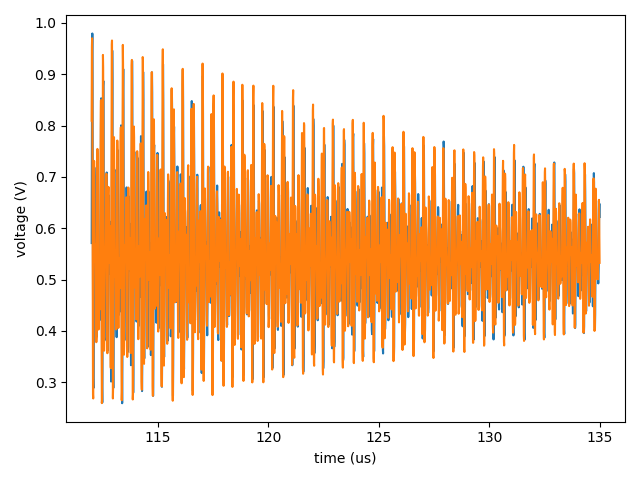

In [184]:
data_number = 1745648  # 1745558
data, header = get_experiment_data(data_number)
fid_params = header["params"]["detect"]["fid"]
start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
fig, ax = plt.subplots()
for kk in range(len(data["transmissions_avg"])):
    times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
    mask = times > start_time
    ax.plot(times[mask] * 1e6, data["transmissions_avg"][kk][mask])

ax.set_xlabel("time (us)")
ax.set_ylabel("voltage (V)")
plt.tight_layout()
plt.show()

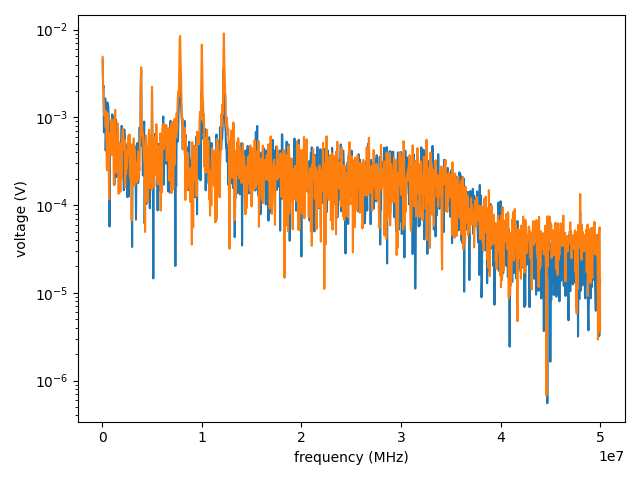

In [181]:
fig, ax = plt.subplots()
for kk in range(len(data["transmissions_avg"])):
    times = np.arange(len(data["transmissions_avg"][kk])) / header["params"]["digitizer"]["sample_rate"]
    mask = times > start_time
    time_resolution = times[1] - times[0]
    duration = times[mask][-1] - times[mask][0]
    N = duration / time_resolution
    ys = 2 * np.fft.rfft(data["transmissions_avg"][kk][mask])[1:] / N
    fs = np.fft.rfftfreq(len(data["transmissions_avg"][kk][mask]), d=time_resolution)[1:]
    ax.plot(fs, np.abs(ys))

ax.set_xlabel("frequency (MHz)")
ax.set_ylabel("voltage (V)")
ax.set_yscale("log")
plt.tight_layout()
plt.show()